In [84]:
print("test aru50 rgi")

test aru50 rgi


In [85]:
from oggm import cfg, utils, workflow, graphics, tasks, DEFAULT_BASE_URL
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from oggm import cfg, utils, workflow, tasks
from oggm.core import gis
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
import os
from oggm.core import inversion
import salem
import xarray as xr
import glob
import os

In [86]:
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['mp_processes'] = 12
# 初始化
cfg.PATHS['working_dir'] = '/mnt/d/lidar/ali/area/same_boundary'
cfg.PARAMS['use_intersects'] = False
rgi_ids = ["RGI60-13.51476"]
# Geometrical centerline
# Where to store the data 

# We start from prepro level 3 with all data ready - note the url here
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3, prepro_border=80, prepro_base_url=base_url)
gdir_cl = gdirs[0]
gdir_cl

2025-10-06 15:23:22: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.


2025-10-06 15:23:22: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-10-06 15:23:22: oggm.cfg: Multiprocessing: using all available processors (N=24)
2025-10-06 15:23:22: oggm.cfg: Multiprocessing switched ON after user settings.
2025-10-06 15:23:22: oggm.cfg: Multiprocessing: using the requested number of processors (N=12)
2025-10-06 15:23:22: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2025-10-06 15:23:23: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-10-06 15:23:23: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


<oggm.GlacierDirectory>
  RGI id: RGI60-13.51476
  Region: 13: Central Asia
  Subregion: 13-08: Inner Tibet                     
  Name: Cn5Z412C0007
  Glacier type: Ice cap
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 4.647 km2
  Lon, Lat: (82.268, 34.005)
  Grid (nx, ny): (227, 235)
  Grid (dx, dy): (40.0, -40.0)

In [87]:
# dem以及GRID投影
cfg.PATHS['dem_file']="/mnt/d/lidar/dh/z_adj_aline/reproject/test/2/20191209_filled_dem.tif"#"/mnt/d/lidar/dh/z_adj_aline/reproject/test/2/20250508_clip.tif"#"/mnt/d/lidar/dh/z_adj_aline/fmt_dat/20140307_clip.tif"
for gdir in gdirs:
    tasks.define_glacier_region(gdir,source='USER')
    gdir.rgi_date = 2019
    gis.process_dem(gdir)
    tasks.glacier_masks(gdir)

In [88]:
from oggm import workflow, tasks

# 1. 定义区域与基础数据
# workflow.execute_entity_task(tasks.define_glacier_region, gdirs, source='SRTM', reset=True)
workflow.execute_entity_task(tasks.glacier_masks, gdirs, reset=True)


workflow.execute_entity_task(tasks.simple_glacier_masks, gdirs, reset=True)

workflow.execute_entity_task(tasks.elevation_band_flowline, gdirs, reset=True)

workflow.execute_entity_task(tasks.fixed_dx_elevation_band_flowline, gdirs, reset=True)

# # 2. 计算流线与集水区
# workflow.execute_entity_task(tasks.compute_centerlines, gdirs, reset=True)
# workflow.execute_entity_task(tasks.initialize_flowlines, gdirs,reset=True)
# workflow.execute_entity_task(tasks.catchment_area, gdirs,reset=True)
# workflow.execute_entity_task(tasks.catchment_intersections, gdirs,reset=True)
# workflow.execute_entity_task(tasks.catchment_width_geom, gdirs,reset=True)
# workflow.execute_entity_task(tasks.catchment_width_correction, gdirs,reset=True)

# 3. 生成下游拓展流线及床形
workflow.execute_entity_task(tasks.compute_downstream_line, gdirs,reset=True)
workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs,reset=True)

# ✅ 4. 【必须】先计算表观质量平衡
workflow.execute_entity_task(tasks.apparent_mb_from_linear_mb, gdirs,reset=True)

# 5. 反演冰厚度
workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs,reset=True)
workflow.execute_entity_task(tasks.mass_conservation_inversion, gdirs,reset=True)

# 6. 平滑并初始化
workflow.execute_entity_task(tasks.filter_inversion_output, gdirs,reset=True)
workflow.execute_entity_task(tasks.process_climate_data, gdirs,reset=True)
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs,reset=True)


2025-10-06 15:23:34: oggm.workflow: Execute entity tasks [glacier_masks] on 1 glaciers
2025-10-06 15:23:35: oggm.workflow: Execute entity tasks [simple_glacier_masks] on 1 glaciers
2025-10-06 15:23:35: oggm.workflow: Execute entity tasks [elevation_band_flowline] on 1 glaciers
2025-10-06 15:23:35: oggm.workflow: Execute entity tasks [fixed_dx_elevation_band_flowline] on 1 glaciers
2025-10-06 15:23:35: oggm.workflow: Execute entity tasks [compute_downstream_line] on 1 glaciers
2025-10-06 15:23:35: oggm.workflow: Execute entity tasks [compute_downstream_bedshape] on 1 glaciers
2025-10-06 15:23:35: oggm.workflow: Execute entity tasks [apparent_mb_from_linear_mb] on 1 glaciers
2025-10-06 15:23:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2025-10-06 15:23:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2025-10-06 15:23:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2025-10-06 15:23:36: oggm

[None]

In [89]:
# fls_cl = gdir_cl.read_pickle('model_flowlines')
fls_cl = gdir_cl.read_pickle('model_flowlines')

Text(0.5, 1.0, 'Geometrical centerline')

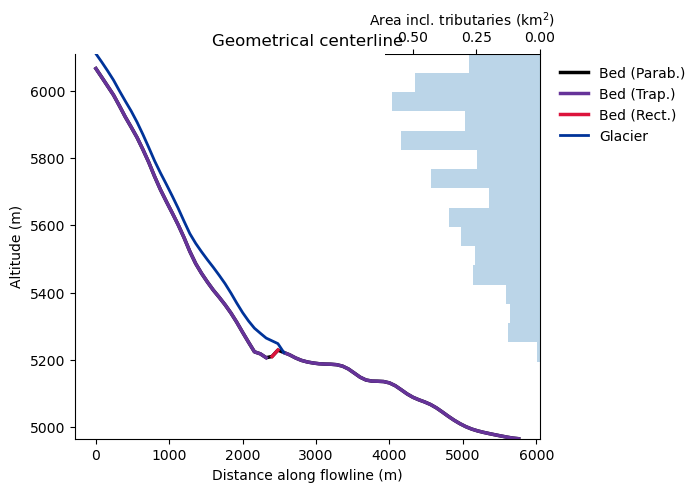

In [90]:
f, ax1= plt.subplots(1, 1, figsize=(6, 5), sharex=True, sharey=True)
graphics.plot_modeloutput_section(fls_cl, ax=ax1)
ax1.set_title('Geometrical centerline')
# graphics.plot_modeloutput_section(fls_eb, ax=ax2)
# ax2.set_title('Elevation band flowline');

In [91]:
#############################################
###冰川主流线厚度、基底高度
#############################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取主流线
fls_cl = gdir_cl.read_pickle('model_flowlines')
fl = fls_cl[-1]  # 一般选择最后一条主流线（最长的）

# 提取数据
dist = fl.dis_on_line  # 沿流线距离（单位：米）
bed_h = fl.bed_h       # 床高
surf_h = fl.surface_h  # 冰面高程
thick = fl.thick       # 冰厚
widths = fl.widths_m   # 冰川宽度

# 整理成 DataFrame
df_profile = pd.DataFrame({
    'Distance [m]': dist,
    'Bed elevation [m]': bed_h,
    'Surface elevation [m]': surf_h,
    'Ice thickness [m]': thick,
    'Glacier width [m]': widths
})

# 保存为 Excel 文件
out_path = '/mnt/d/lidar/projection/aru50_centerline_profile_rgi.xlsx'
df_profile.to_excel(out_path, index=False)
print(f'保存成功：{out_path}')


保存成功：/mnt/d/lidar/projection/aru50_centerline_profile_rgi.xlsx


In [92]:
gdirs = [gdir_cl]

In [93]:
from oggm.shop import gcm_climate

# you can choose one of these 5 different GCMs:
# 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
# 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
member = 'mri-esm2-0_r1i1p1f1' 

for ssp in ['ssp126', 'ssp370','ssp585']:
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                                 ssp = ssp,
                                 # gcm member -> you can choose another one
                                 member=member,
                                 # recognize the climate file for later
                                 output_filesuffix=f'_ISIMIP3b_{member}_{ssp}'
                                 );

2025-10-06 15:23:48: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2025-10-06 15:23:50: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2025-10-06 15:23:51: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers


In [94]:
# add additional outputs to default OGGM
cfg.PARAMS['store_model_geometry'] = True  
cfg.PARAMS['store_fl_diagnostics'] = True

for gdir in gdirs:
    if gdir is gdir_cl:
        cfg.PARAMS['evolution_model'] = 'FluxBased'
    else:
        cfg.PARAMS['evolution_model'] = 'SemiImplicit'

    workflow.execute_entity_task(tasks.run_from_climate_data, [gdir],
                                 output_filesuffix='_historical',  
                                );

    for ssp in ['ssp126', 'ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'

        workflow.execute_entity_task(tasks.run_from_climate_data, [gdir],
                                     climate_filename='gcm_data',#'gcm_data',  # use gcm_data, not climate_historical
                                     climate_input_filesuffix=rid,  # use the chosen scenario
                                     init_model_filesuffix='_historical',  # this is important! Start from 2020 glacier
                                     output_filesuffix=rid,  # recognize the run for later
                                    );

2025-10-06 15:23:55: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2025-10-06 15:23:55: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.
2025-10-06 15:23:55: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.
2025-10-06 15:23:55: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-10-06 15:23:55: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-10-06 15:23:56: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-10-06 15:23:56: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers


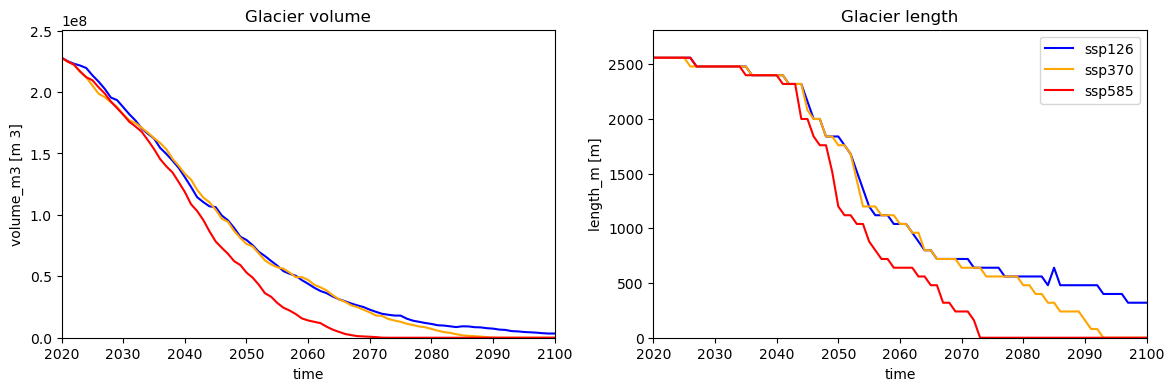

In [95]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Pick some colors for the lines
color_dict={'ssp126':'blue', 'ssp370':'orange', 'ssp585':'red'}

for ssp in ['ssp126','ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
        ds.volume_m3.plot(ax=ax1, label=ssp, c=color_dict[ssp]);
    ax1.set_title('Glacier volume')
    ax1.set_xlim([2020,2100])
    ax1.set_ylim([0, ds.volume_m3.max().max()*1.1])

for ssp in ['ssp126','ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
        ds.length_m.plot(ax=ax2, label=ssp, c=color_dict[ssp]);
    ax2.set_ylim([0, ds.length_m.max().max()*1.1])
    # ax2.set_xlim([2020,2100])
# for ssp in ['ssp126','ssp370', 'ssp585']:
#     rid = f'_ISIMIP3b_{member}_{ssp}'
#     with xr.open_dataset(gdir_eb.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
#         ds.length_m.plot(ax=ax2, label=ssp, c=color_dict[ssp], ls='--');
    ax2.set_title('Glacier length')
    ax2.set_xlim([2020,2100])
    
plt.legend();   

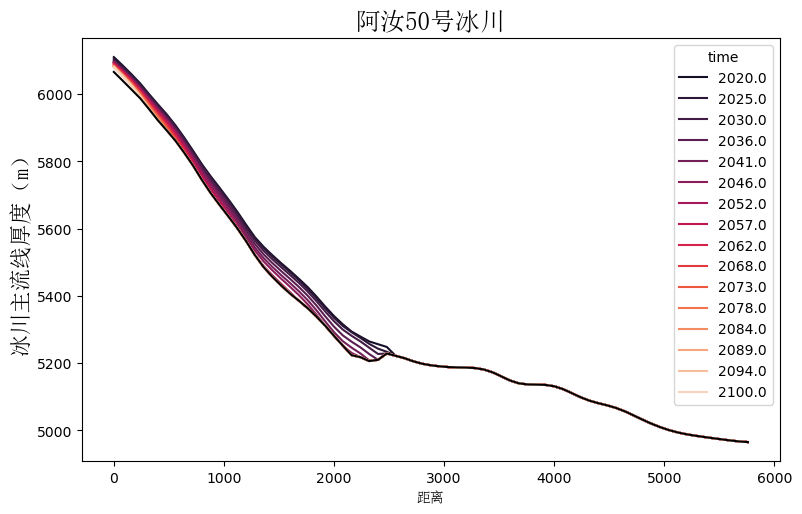

In [96]:
from matplotlib import font_manager as fm
font_path = '/usr/share/fonts/simsun.ttc'
my_font = fm.FontProperties(fname=font_path)
rid = f'_ISIMIP3b_{member}_ssp126'
sel_years = np.linspace(2020, 2100, 16).astype(int)
colors = sns.color_palette('rocket', len(sel_years))
with plt.rc_context({'axes.prop_cycle': plt.cycler(color=colors)}):
    f, ax1= plt.subplots(1, 1, figsize=(9, 5.5), sharey=True, sharex=True)
    n_lines = len(gdir_cl.read_pickle('model_flowlines'))
    with xr.open_dataset(gdir_cl.get_filepath('fl_diagnostics', filesuffix=rid), group=f'fl_{n_lines-1}') as ds:
        (ds.bed_h + ds.sel(time=sel_years).thickness_m).plot(ax=ax1, hue='time')
        ds.bed_h.plot(ax=ax1, c='k')
        ax1.set_title('阿汝50号冰川',fontproperties=my_font,fontsize=18)
        ax1.set_ylabel('冰川主流线厚度（m）', fontproperties=my_font,fontsize=16)
        ax1.set_xlabel('距离', fontproperties=my_font)  
    # with xr.open_dataset(gdir_eb.get_filepath('fl_diagnostics', filesuffix=rid), group='fl_0') as ds:
    #     (ds.bed_h + ds.sel(time=sel_years).thickness_m).plot(ax=ax2, hue='time')
    #     ds.bed_h.plot(ax=ax2, c='k')
    #     ax2.set_ylabel('')
    #     ax2.set_title('Elevation bands')

In [97]:
########################################################
####   将预测的主流线高度分别保存为 xls（ssp126, ssp370, ssp585）
########################################################
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib
from matplotlib import font_manager as fm
font_path = '/usr/share/fonts/simsun.ttc'
my_font = fm.FontProperties(fname=font_path)

# 选择年份
# sel_years = np.linspace(2020, 2100, 80).astype(int)  # 每5年一个，共17个年份
sel_years = np.arange(2020, 2101, 1)
# 情景列表
ssp_list = ['ssp126', 'ssp370', 'ssp585']

# 获取主流线数量
n_lines = len(gdir_cl.read_pickle('model_flowlines'))

for ssp in ssp_list:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('fl_diagnostics', filesuffix=rid), group=f'fl_{n_lines-1}') as ds:

        # 提取床高和厚度
        bed_h = ds.bed_h.values
        dist = ds.dis_along_flowline.values
        thick = ds.thickness_m.sel(time=sel_years)
        surface = (thick + ds.bed_h).transpose('time', 'dis_along_flowline')  # 行是年份，列是距离

        # 转为 DataFrame
        df_surface = pd.DataFrame(
            surface.values,
            index=sel_years,
            columns=[f'{int(d)} m' for d in dist]
        )
        df_surface.index.name = 'Year'

        # 输出路径
        out_path = f'/mnt/d/lidar/projection/aru50_thickness_profile_{ssp}_rgi.xlsx'
        df_surface.to_excel(out_path)
        print(f'{ssp} 数据保存成功：{out_path}')

ssp126 数据保存成功：/mnt/d/lidar/projection/aru50_thickness_profile_ssp126_rgi.xlsx
ssp370 数据保存成功：/mnt/d/lidar/projection/aru50_thickness_profile_ssp370_rgi.xlsx
ssp585 数据保存成功：/mnt/d/lidar/projection/aru50_thickness_profile_ssp585_rgi.xlsx


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d/lidar/ali/area/same_boundary/per_glacier/RGI60-13/RGI60-13.51/RGI60-13.51476/model_diagnostics_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126.nc'

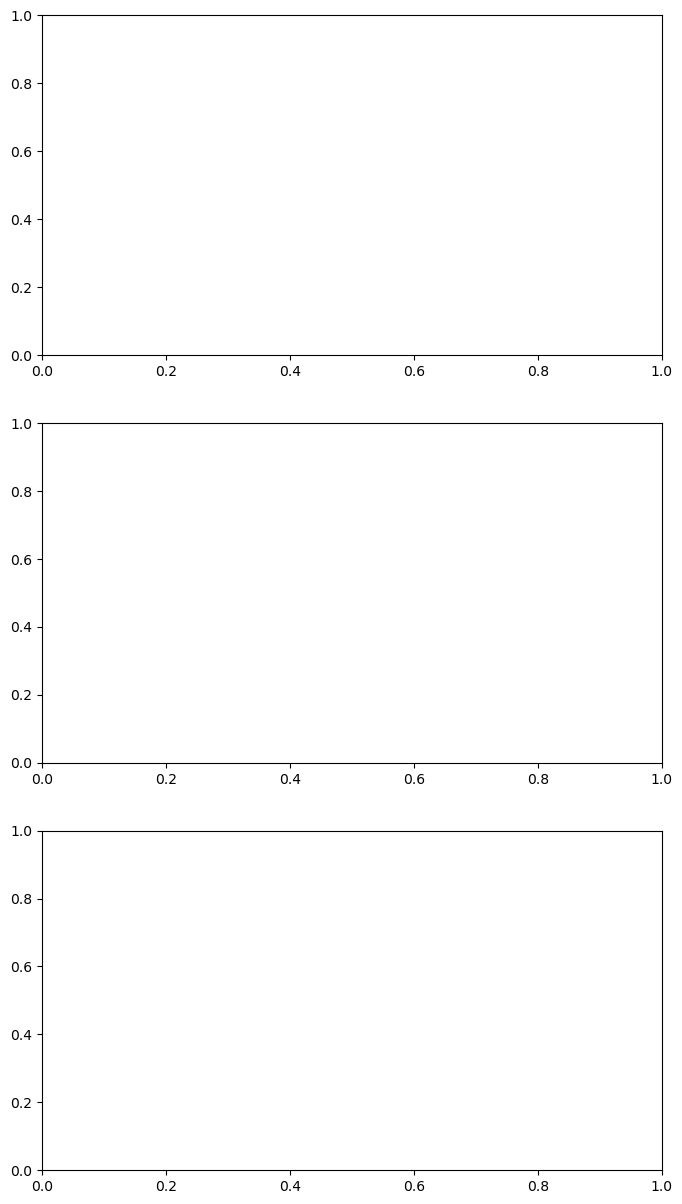

In [100]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager as fm

import pandas as pd


font_path = '/usr/share/fonts/simsun.ttc'
my_font = fm.FontProperties(fname=font_path)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 15))


color_dict = {
    'ssp126': '#6baed6',  # 淡蓝
    'ssp370': '#c2b0d9',  # 淡紫（替代原淡红）
    'ssp585': '#a1d99b'   # 淡绿
}


smooth_win = 15

# 为柱状图定义偏移和宽度，避免重叠
ssp_list = ['ssp126', 'ssp370', 'ssp585']
bar_width = 0.8
offsets = np.linspace(-bar_width, bar_width, len(ssp_list))  # [-0.25, 0, 0.25]

for i, ssp in enumerate(ssp_list):
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
        vol_smooth = ds.volume_m3.rolling(time=smooth_win, center=True, min_periods=1).mean()
        len_smooth = ds.length_m.rolling(time=smooth_win, center=True, min_periods=1).mean()
        area_smooth = (ds.area_m2 / 1e6).rolling(time=smooth_win, center=True, min_periods=1).mean()

        time = vol_smooth['time'].values
        time_num = np.arange(0,len(time))
        # 并列柱状图，x轴偏移防止重叠
        ax1.bar(time, ds.volume_m3.values, width=bar_width,alpha=0.8, label=ssp, color=color_dict[ssp], align='center')

        # 长度折线图
        ax2.plot(time, len_smooth.values, label=ssp, color=color_dict[ssp])

        # 面积填充图，alpha较低避免叠色过深
        ax3.fill_between(time, 0, area_smooth.values, label=ssp,
                         color=color_dict[ssp], alpha=0.6)
        ax3.plot(time, area_smooth.values, color=color_dict[ssp])

# 设置标题和轴范围
fntsize1=24
fntsize2=22
ax1.set_title('阿汝50号2020年-2100年冰川体积(m³)',fontproperties=my_font, fontsize=fntsize1)
ax1.set_xlabel('年份', fontproperties=my_font,fontsize=fntsize2)   

# ax1.set_xlim(0, len(time ) - 1)
# ax1.set_xticks(np.arange(0, len(time), 10))
# time = vol_smooth['time'].values
# time_num = np.arange(len(time))
time1=time[0::][::10]
# time1=[2025, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
ax1.set_xlim(time[0], time[-1])
ax1.set_xticks(time1)
ax1.set_xticklabels(time1.astype(int))

ax1.set_ylim(bottom=0)#top=250000000,
ax1.set_ylabel('冰川体积', fontproperties=my_font,fontsize=fntsize2)   

ax2.set_title('阿汝50号2020年-2100年冰川长度(m)',fontproperties=my_font,fontsize=fntsize1)
ax2.set_xlabel('年份', fontproperties=my_font,fontsize=fntsize2)      
ax2.set_xlim(time[0], time[-1])
ax2.set_xticks(time1)
ax2.set_xticklabels(time1.astype(int))

ax2.set_ylim(bottom=0)#,top=3000
ax2.set_ylabel('冰川长度',fontproperties=my_font,fontsize=fntsize2)   

ax3.set_title('阿汝50号2020年-2100年冰川面积(km²)',fontproperties=my_font,fontsize=fntsize1)
ax3.set_xlabel('年份', fontproperties=my_font,fontsize=fntsize2)   
ax3.set_xlim(time[0], time[-1])
ax3.set_xticks(time1)
ax3.set_xticklabels(time1.astype(int))
ax3.set_ylim(bottom=0)#,top=5
ax3.set_ylabel('冰川面积',fontproperties=my_font,fontsize=fntsize2)   
for ax in (ax1, ax2, ax3):
    ax.tick_params(labelsize=14)  # 刻度字体大小
    ax.legend(loc='upper right', prop={'family': 'Times New Roman', 'size': 16})
# for ax in (ax1, ax2, ax3):
#     ax.legend(loc='upper right',prop='Times New Roman')
plt.tight_layout()
plt.show()

# 创建一个空的字典来存储每个情景下的数据
data_dict = {}

# 重新读取数据（也可以从已处理的变量中提取）
for ssp in ssp_list:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    with xr.open_dataset(gdir_cl.get_filepath('model_diagnostics', filesuffix=rid)) as ds:
        vol_smooth = ds.volume_m3.rolling(time=smooth_win, center=True, min_periods=1).mean()
        len_smooth = ds.length_m.rolling(time=smooth_win, center=True, min_periods=1).mean()
        area_smooth = (ds.area_m2 / 1e6).rolling(time=smooth_win, center=True, min_periods=1).mean()

        time = pd.to_datetime(vol_smooth['time'].values).year  # 提取年份
        data_dict[f'{ssp}_volume_m3'] = vol_smooth.values
        data_dict[f'{ssp}_length_m'] = len_smooth.values
        data_dict[f'{ssp}_area_km2'] = area_smooth.values

# 把时间加进去
data_dict['Year'] = time

# 创建 DataFrame（以 Year 为索引更清晰）
df = pd.DataFrame(data_dict)
df = df[['Year'] + [col for col in df.columns if col != 'Year']]  # 确保 Year 列在最前面

# 保存为 Excel
output_path = r'/mnt/d/lidar/projection/aru50_glacier_projection_rgi.xlsx'
df.to_excel(output_path, index=False)
print(f"数据成功保存到：{output_path}")